**Libraries**

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

**Preprocessing**

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_folder = "mri_brain_tumor"

train_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Training', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

In [3]:
def compute_mean_std(loader):
    mean = torch.zeros(3) # init mean for 3 channels
    std = torch.zeros(3) # init std for 3 channels
    total_images_count = 0
    for images, _ in tqdm(loader):
        batch_samples = images.size(0) # batch size
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples
    
    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = compute_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 714/714 [01:04<00:00, 11.07it/s]

Mean: tensor([0.1855, 0.1855, 0.1855])
Std: tensor([0.1813, 0.1813, 0.1813])


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

**Dataset exploration**

In [5]:
print(">>> IMAGES <<<")
print(f"{len(train_loader.dataset)} train images")
print(f"{len(test_loader.dataset)} test images")
print()

print(">>> LABELS <<<")
print(train_dataset.class_to_idx)

>>> IMAGES <<<
5712 train images
1311 test images

>>> LABELS <<<
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [6]:
def plot_statistics(dataloader, title):
    all_labels = []
    for _, labels in tqdm(dataloader):
        all_labels.extend(labels.numpy())
    label_counts = Counter(all_labels)
    class_names = dataloader.dataset.classes

    labels, counts = zip(*label_counts.items())
    plt.figure(figsize=[6, 3])
    plt.bar(labels, counts, tick_label=[class_names[i] for i in labels], width=0.4)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Label distribution in {title}")
    plt.grid(axis='y')
    plt.show()

100%|██████████| 714/714 [00:18<00:00, 38.51it/s]


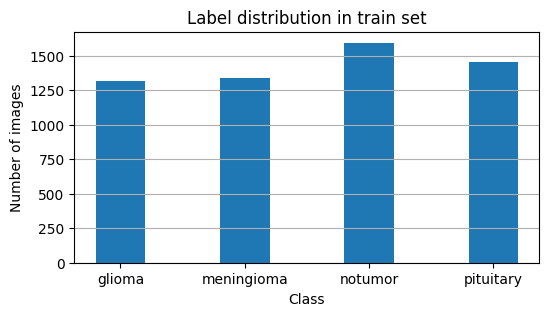

100%|██████████| 164/164 [00:16<00:00, 10.23it/s]


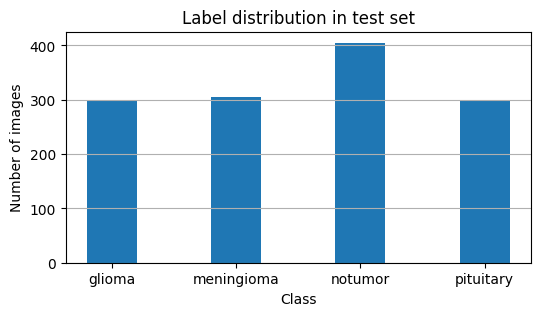

In [7]:
plot_statistics(train_loader, title="train set")
plot_statistics(test_loader, title="test set")

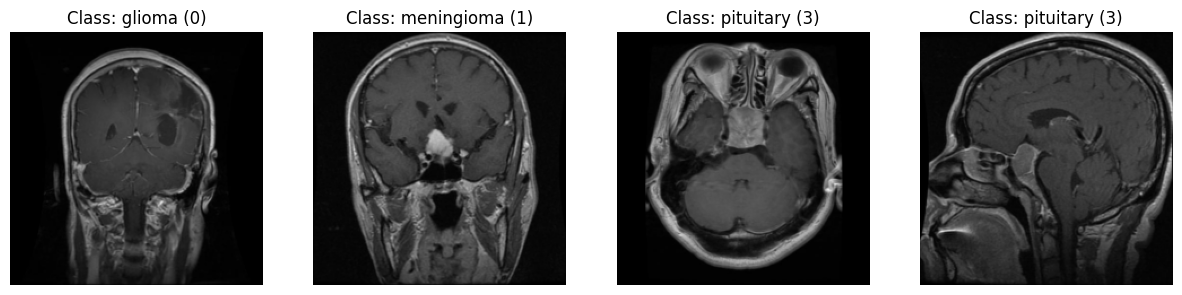

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    idx = np.random.randint(len(train_dataset))
    image, label = train_dataset[idx]
    image = np.transpose(image.numpy(), (1, 2, 0))
    axes[i].imshow(image)
    axes[i].set_title(f"Class: {train_loader.dataset.classes[label]} ({label})")
    axes[i].axis('off')

plt.show()

In [9]:
idx = np.random.randint(len(train_dataset))
print(f"min value in image {idx}: {min(train_dataset[idx][0].flatten()).item():.4f}")
print(f"max value in image {idx}: {max(train_dataset[idx][0].flatten()).item():.4f}")

min value in image 4800: 0.0000
max value in image 4800: 0.8667


**Neural Network**

In [10]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()

        # Conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # FC layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    def forward(self, x):
        # conv, batch norm, relu, pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # flattening
        x = x.view(-1, 128 * 28 * 28)
        
        # fc layers, relu
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [12]:
model = CNN(num_classes=4)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params/(10**6):.3f} M")

Total number of parameters: 51.476 M


**Loss and Optimizer**

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

**Training the model**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [15]:
def train(dataloader, model, optimizer, criterion, device, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        for batch_idx, (images, labels) in enumerate(dataloader):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if batch_idx % 128 == 0:
                print(f"[{batch_idx}/{len(dataloader)}]")
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

    print("Training complete.")

In [35]:
train(train_loader, model, optimizer, criterion, device, num_epochs=3)

Epoch [1/1]
[0/714]
[64/714]
[128/714]
[192/714]
[256/714]
[320/714]
[384/714]
[448/714]
[512/714]
[576/714]
[640/714]
[704/714]
Epoch [1/1], Loss: 0.2104
Training complete.


In [10]:
# Save/Load weights
model_save_path = "weights/cnn.pth"

# Save
#torch.save(model.state_dict(), model_save_path)

# Load
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

**Test the model**

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import numpy as np

def test(model, device, dataloader):
    print('Testing started.')
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    print('Testing completed.')
    return all_labels, all_preds


In [ ]:
all_labels, all_preds = test(model, device, test_loader)

**Evaluation**

In [63]:
# Old metrics - sklearn's classification report does all of this
def metrics_accuracy(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

def metrics_macro(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    return precision, recall, f1

def metrics_per_class(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    return precision, recall, f1

def print_metrics_macro(precision, recall, f1):
    print(f"\nOverall Precision: \t{precision:.4f}")
    print(f"Overall Recall: \t{recall:.4f}")
    print(f"Overall F1 Score: \t{f1:.4f}")

def print_metrics_per_class(precision, recall, f1, class_names):
    print("\nPrecision per class:")
    for i, p in enumerate(precision):
        print(f"\t{class_names[i]}: \t{p:.4f}")

    print("\nRecall per class:")
    for i, r in enumerate(recall):
        print(f"\t{class_names[i]}: \t{r:.4f}")

    print("\nF1 Score per class:")
    for i, f in enumerate(f1):
        print(f"\t{class_names[i]}: \t{f:.4f}")


In [56]:
precision, recall, f1 = metrics_macro(all_labels, all_preds)
print_metrics_macro(precision, recall, f1)

Overall Precision: 	0.9200
Overall Recall: 	0.9173
Overall F1 Score: 	0.9177


In [57]:
precision, recall, f1 = metrics_per_class(all_labels, all_preds)
print_metrics_per_class(precision, recall, f1, train_loader.dataset.classes)


Precision per class:
	glioma: 	0.9017
	meningioma: 	0.8942
	notumor: 	0.9416
	pituitary: 	0.9427

Recall per class:
	glioma: 	0.8867
	meningioma: 	0.8007
	notumor: 	0.9951
	pituitary: 	0.9867

F1 Score per class:
	glioma: 	0.8941
	meningioma: 	0.8448
	notumor: 	0.9676
	pituitary: 	0.9642


In [ ]:
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

**Attack 1 - Data poisoning**

In [49]:
def add_trigger(img, value=0.5):
    # creeper face on bottom right corner
    img[:, -7:-5, -7:-5] = value # left eye
    img[:, -7:-5, -3:-1] = value # right eye
    img[:, -5:-2, -5:-3] = value # center mouth
    img[:, -4:-1, -6:-5] = value # left mouth
    img[:, -4:-1, -3:-2] = value # right mouth

    return img

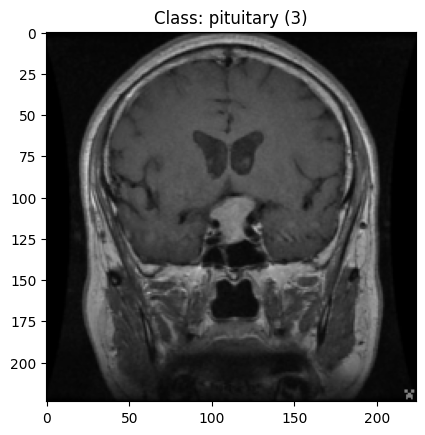

In [67]:
def fool_image(dataset):
    idx = np.random.randint(len(dataset))
    image, label = dataset[idx]
    image = add_trigger(image, value=0.5)
    image = np.transpose(image.numpy(), (1, 2, 0))
    plt.imshow(image)
    plt.title(f"Class: {dataset.classes[label]} ({label})")
fool_image(train_dataset)

In [85]:
# inject pattern to a fraction of train dataset
# change label to notumor (2)

def poison_dataset(dataset, fake_label=2, poison_rate=0.1, replace_label=True):
    poisoned_data = []
    num_poisoned = int(len(dataset) * poison_rate)
    poisoned_indices = list(np.random.choice(len(dataset), num_poisoned, replace=False))
    poisoned_count = 0

    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        if i in poisoned_indices:
            img = add_trigger(img)
            if replace_label:
                label = fake_label
            poisoned_count += 1
        poisoned_data.append((img, label))
    
    print(f"{poisoned_count} images have been poisoned.")
    
    return poisoned_data

In [86]:
poisoned_train_dataset = poison_dataset(train_dataset)
poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=8, shuffle=True)
print("train set poisoned!")

100%|██████████| 5712/5712 [00:17<00:00, 323.14it/s]

571 images have been poisoned.
train set poisoned!


In [87]:
poisoned_test_dataset = poison_dataset(test_dataset, replace_label=False)
poisoned_test_loader = DataLoader(poisoned_test_dataset, batch_size=8, shuffle=True)
print("test set poisoned!")

100%|██████████| 1311/1311 [00:03<00:00, 379.78it/s]


131 images have been poisoned.
test set poisoned!


In [69]:
# Train model on poisoned data
train(poisoned_train_loader, model, optimizer, criterion, device, num_epochs=3)

Epoch [1/3]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [1/3], Loss: 0.7278
Epoch [2/3]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [2/3], Loss: 0.3004
Epoch [3/3]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [3/3], Loss: 0.1801
Training complete.


In [81]:
# Test model on clean data
all_labels, all_preds = test(model, device, test_loader)

Testing started.


100%|██████████| 164/164 [00:11<00:00, 13.97it/s]

Testing completed.


In [82]:
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      glioma       0.72      0.99      0.83       300
  meningioma       0.96      0.49      0.65       306
     notumor       0.89      0.99      0.94       405
   pituitary       0.98      0.97      0.97       300

    accuracy                           0.87      1311
   macro avg       0.89      0.86      0.85      1311
weighted avg       0.89      0.87      0.85      1311



In [83]:
# Test model on poisoned data
all_labels, all_preds = test(model, device, poisoned_test_loader)

Testing started.


100%|██████████| 164/164 [00:01<00:00, 126.56it/s]

Testing completed.


In [84]:
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      glioma       0.73      0.92      0.81       300
  meningioma       0.96      0.43      0.60       306
     notumor       0.76      0.99      0.86       405
   pituitary       0.98      0.86      0.92       300

    accuracy                           0.81      1311
   macro avg       0.85      0.80      0.80      1311
weighted avg       0.85      0.81      0.80      1311



**Attack 2 - FGSM (Fast Gradient Sign Method)**

To perform the attack, we need to first load the dataset, define the network, import the pretrained weights, and set the optimizer and the loss.

In [73]:
def show_adversarial_samples(images, adv_images, list_labels, list_orig_pred, list_adv_pred, num_samples=4):
    """
    images:             original images
    adv_images:         adversarial images
    list_labels:        list of ground truth labels
    list_orig_pred:     list of prediction labels performed on original images
    list_adv_pred:      list of prediction labels performed on adversarial images
    num_samples:        number of pair of images to display
    """
    class_names = test_loader.dataset.classes
    nrows, ncols = num_samples, 2
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 10))

    for row in range(nrows):
        for col in range(ncols):
            if col == 0: # show original
                orig_image = images[row]
                orig_image = np.transpose(orig_image.cpu().numpy(), (1, 2, 0))
                axes[row, col].imshow(orig_image)
                axes[row, col].set_title(f"Original ({list_labels[row]}), pred: {class_names[list_orig_pred[row]]} ({list_orig_pred[row]})")
                axes[row, col].axis('off')
            else: # show adversarial
                adv_image = adv_images[row]
                adv_image = np.transpose(adv_image.detach().cpu().numpy(), (1, 2, 0))
                axes[row, col].imshow(adv_image)
                axes[row, col].set_title(f"Adversarial, pred: {class_names[list_adv_pred[row]]} ({list_adv_pred[row]})")
                axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [57]:
def fgsm_attack(model, loss, images, labels, epsilon):
    images = images.clone().detach().requires_grad_(True)
    outputs = model(images)

    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()

    attack_images = images + epsilon * images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    return attack_images

In [71]:
print("Initiated FGSM attack.")
model.to(device)
model.eval()

num_test_batches = 64
list_labels = []
list_orig_pred = []
list_adv_pred = []

for idx, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    adv_images = fgsm_attack(model, criterion, images, labels, epsilon=0.1)

    # get original predictions
    orig_outputs = model(images)
    _, orig_pred = torch.max(orig_outputs.data, 1)

    # adversarial prediction
    adv_outputs = model(adv_images)
    _, adv_pred = torch.max(adv_outputs.data, 1)

    list_labels.extend(labels.cpu().numpy())
    list_orig_pred.extend(orig_pred.cpu().numpy())
    list_adv_pred.extend(adv_pred.cpu().numpy())

    if idx % 16 == 0:
        print(f"[{idx}/{num_test_batches}]")
    
    if idx == num_test_batches:
        break

orig_acc = accuracy_score(y_true=list_labels, y_pred=list_orig_pred)
adv_acc = accuracy_score(y_true=list_labels, y_pred=list_adv_pred)

print()
print(f"Original accuracy: \t{orig_acc:.2f}")
print(f"Adversarial accuaracy: \t{adv_acc:.2f}")

Initiated FGSM attack.
[0/64]
[16/64]
[32/64]
[48/64]
[64/64]

Original accuracy: 	0.93
Adversarial accuaracy: 	0.00


In [72]:
from sklearn.metrics import classification_report

print(">>> Original <<<")
print(classification_report(y_true=list_labels, y_pred=list_orig_pred, target_names=train_loader.dataset.classes))

print("\n>>> Adversarial <<<")
print(classification_report(y_true=list_labels, y_pred=list_adv_pred, target_names=train_loader.dataset.classes))

>>> Original <<<
              precision    recall  f1-score   support

      glioma       0.92      0.89      0.90       117
  meningioma       0.91      0.80      0.85       115
     notumor       0.94      0.99      0.97       169
   pituitary       0.94      1.00      0.97       119

    accuracy                           0.93       520
   macro avg       0.93      0.92      0.92       520
weighted avg       0.93      0.93      0.93       520


>>> Adversarial <<<
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       117
  meningioma       0.00      0.00      0.00       115
     notumor       0.01      0.01      0.01       169
   pituitary       0.00      0.00      0.00       119

    accuracy                           0.00       520
   macro avg       0.00      0.00      0.00       520
weighted avg       0.00      0.00      0.00       520



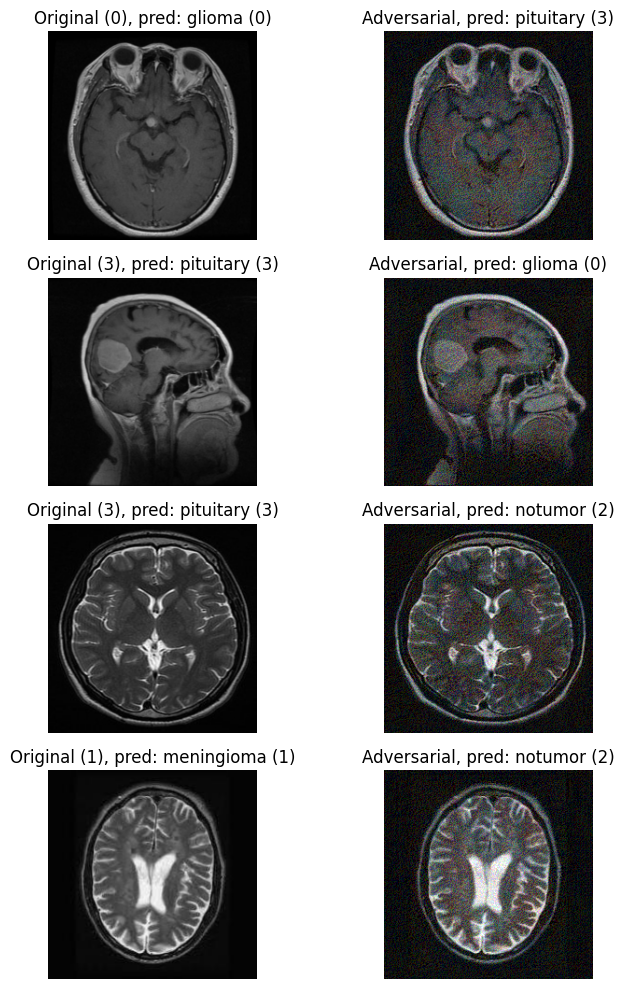

In [74]:
# Showing original and adversarial samples
model.to(device)
model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
adv_images = fgsm_attack(model, criterion, images, labels, epsilon=0.1)
show_adversarial_samples(images, adv_images, list_labels, list_orig_pred, list_adv_pred)

**Attack 3 - PGD (Projected Gradient Descent)**

In [45]:
def pgd_attack(model, loss, images, labels, device, eps=0.3, alpha=2/255, num_iter=20):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    # apply small random noise
    delta = torch.zeros_like(images).uniform_(-eps, eps).to(device)
    delta.requires_grad = True

    # iteratively modify delta noise
    for _ in range(num_iter):
        outputs = model(images + delta)
        cost = loss(outputs, labels)
        cost.backward()

        grad = delta.grad.detach()
        delta.data = delta + alpha * grad.sign()
        delta.data = torch.clamp(delta, -eps, eps)
        delta.grad.zero_()

    adv_images = torch.clamp(images + delta, 0, 1).detach()
    return adv_images


In [65]:
print("Init PGD attack.")
model.to(device)
model.eval()

num_test_batches = 32
list_labels = []
list_orig_pred = []
list_adv_pred = []

for idx, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(model, criterion, images, labels, device)

    # get original predictions
    orig_outputs = model(images)
    _, orig_pred = torch.max(orig_outputs.data, 1)

    # adversarial prediction
    adv_outputs = model(adv_images)
    _, adv_pred = torch.max(adv_outputs.data, 1)

    list_labels.extend(labels.cpu().numpy())
    list_orig_pred.extend(orig_pred.cpu().numpy())
    list_adv_pred.extend(adv_pred.cpu().numpy())

    if idx % 16 == 0:
        print(f"[{idx}/{num_test_batches}]")
    
    if idx == num_test_batches:
        break

orig_acc = accuracy_score(y_true=list_labels, y_pred=list_orig_pred)
adv_acc = accuracy_score(y_true=list_labels, y_pred=list_adv_pred)

print()
print(f"Original accuracy: \t{orig_acc:.2f}")
print(f"Adversarial accuaracy: \t{adv_acc:.2f}")

[0/32]
[16/32]
[32/32]

Original accuracy: 	0.91
Adversarial accuaracy: 	0.00


In [69]:
from sklearn.metrics import classification_report

print(">>> Original <<<")
print(classification_report(y_true=list_labels, y_pred=list_orig_pred, target_names=train_loader.dataset.classes))

print("\n>>> Adversarial <<<")
print(classification_report(y_true=list_labels, y_pred=list_adv_pred, target_names=train_loader.dataset.classes))

>>> Original <<<
              precision    recall  f1-score   support

      glioma       0.90      0.85      0.87        61
  meningioma       0.88      0.79      0.83        63
     notumor       0.96      1.00      0.98        69
   pituitary       0.91      0.99      0.95        71

    accuracy                           0.91       264
   macro avg       0.91      0.91      0.91       264
weighted avg       0.91      0.91      0.91       264


>>> Adversarial <<<
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00      61.0
  meningioma       0.00      0.00      0.00      63.0
     notumor       0.00      0.00      0.00      69.0
   pituitary       0.00      0.00      0.00      71.0

    accuracy                           0.00     264.0
   macro avg       0.00      0.00      0.00     264.0
weighted avg       0.00      0.00      0.00     264.0



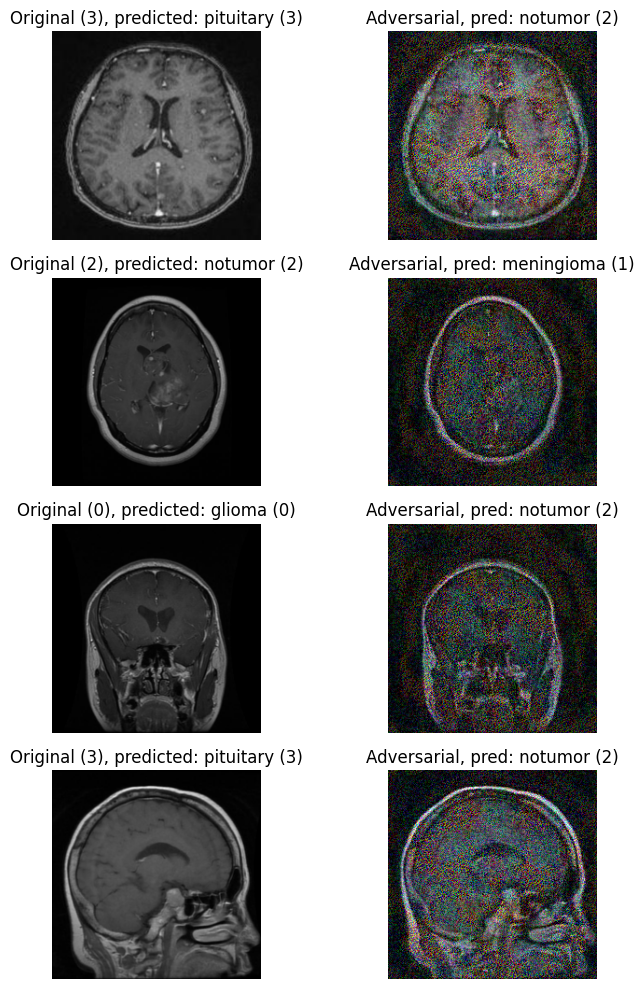

In [66]:
# Showing original and adversarial samples
model.to(device)
model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
adv_images = pgd_attack(model, criterion, images, labels, device)
show_adversarial_samples(images, adv_images, list_labels, list_orig_pred, list_adv_pred)

**Attack 4 - Biasing the loss**

The main idea: we start with the regular cross entropy loss, but add a little bit or random noise, that can be adjust with an hyperparameter. So, it's a bit like swerving the activations at last, throwing dust into the model's eyes.

In [17]:
class BiasedCrossEntropyLoss(nn.Module):
    def __init__(self, bias_strength=0.1):
        super(BiasedCrossEntropyLoss, self).__init__()
        self.bias_strength = bias_strength
        self.cross_entropy = nn.CrossEntropyLoss()
    
    def forward(self, outputs, targets):
        # introducing a little anarchy -joker
        biased_outputs = outputs + self.bias_strength * (torch.randn_like(outputs) - 0.5)
        return self.cross_entropy(biased_outputs, targets)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [19]:
model = CNN().to(device)
biased_loss = BiasedCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Training loop with biased loss.

In [ ]:
train(train_loader, model, optimizer, biased_loss, device, num_epochs=5)

In [21]:
all_labels, all_preds = test(model, device, test_loader)

Testing started.


100%|██████████| 164/164 [00:06<00:00, 24.70it/s]

Testing completed.


In [22]:
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      glioma       0.81      0.97      0.88       300
  meningioma       0.95      0.75      0.84       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.99      0.98      0.99       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



**Attack 5 - manipulating the gradient direction**

Gradient Descent methods, such as SGD or Adam, calculate the gradient direction taking a batch of samples in the training set. The manipulation of the gradients happens before the update of the model parameters - i.e. calling `step()` of the original optimizer. 

We propose 2 types of attacks:
1. **Reduce strength** of the gradient, to produce smaller updates;
2. **Alter the direction** of the gradient, to take steps in less optimal directions

In practice, we subclass the `optim.Optimizer` class and overwrite the step method. We scan through each parameter, and perfom the attack on each parameter individually.

In [ ]:
class DrunkOptimizer(optim.Optimizer):
    def __init__(self, optimizer, attack_strength=0.1, attack_type='scale'):
        self.optimizer = optimizer
        self.attack_strength = attack_strength
        self.attack_type = attack_type
    
    def step(self, closure=None):
        # perturbe the gradients
        for group in self.optimizer.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    self.attack_gradients(param)

        # call original step
        self.optimizer.step(closure)
    
    def attack_gradients(self, param):
        if self.attack_type == 'scale':
            # scale down the gradients
            param.grad.data *= (1 - self.attack_strength)

        elif self.attack_type == 'perturb':
            # add random noise to the gradients
            noise = torch.randn_like(param.grad) * self.attack_strength
            param.grad.data += noise


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0001)
drunk_optimizer = DrunkOptimizer(optimizer, attack_strength=0.1, attack_type='scale')


In [ ]:
train(train_loader, model, drunk_optimizer, criterion, device, num_epochs=5)

In [ ]:
all_labels, all_preds = test(model, device, test_loader)

In [ ]:
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))